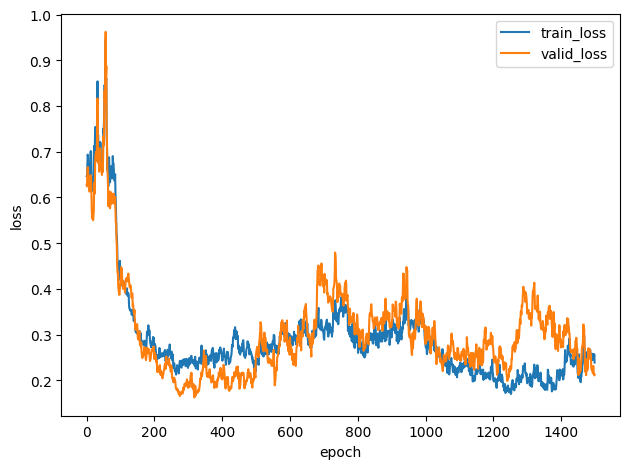

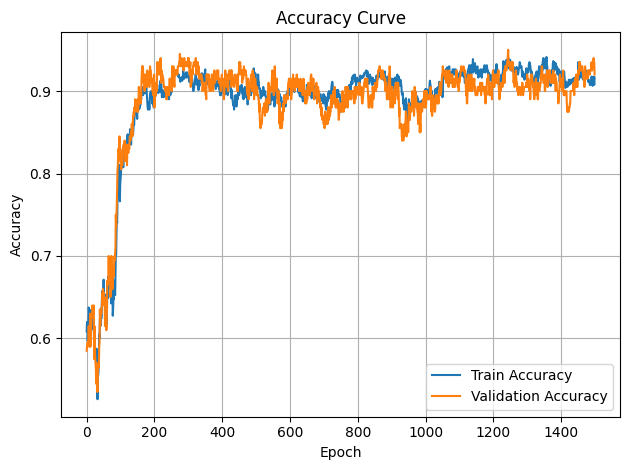

In [4]:
#CLASSIFICATION

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pyperch import Trainer
from pyperch.config import TrainConfig, OptimizerConfig
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_accuracy

# ------------------------------
# Repro
# ------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Classification data
# ------------------------------
X, y = make_classification(
    n_samples=1000,
    n_features=12,
    n_informative=10,
    n_classes=2,
    random_state=seed
)
X = X.astype(np.float32)
y = y.astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train), torch.tensor(y_train)),
    batch_size=64,
    shuffle=True
)
valid_loader = DataLoader(
    TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid)),
    batch_size=128
)

# ------------------------------
# Model
# ------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )
    def forward(self, x):
        return self.net(x)

model = SimpleClassifier()
loss_fn = nn.CrossEntropyLoss()

# ------------------------------
# SA config
# ------------------------------
opt_cfg = OptimizerConfig(
    name="sa",
    t=2.0,
    t_min=0.001,
    cooling=0.995,
    step_size=0.05,
)

cfg = TrainConfig(
    device="cpu",
    seed=seed,
    max_epochs=1500,
    optimizer="sa",
    optimizer_config=opt_cfg,
    optimizer_mode="per_batch",
    metrics={"train": [Accuracy()], "valid": [Accuracy()]},
)

trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)
plot_accuracy(history)


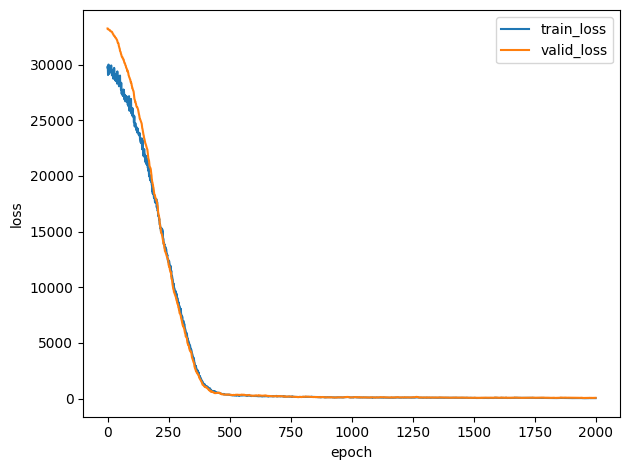

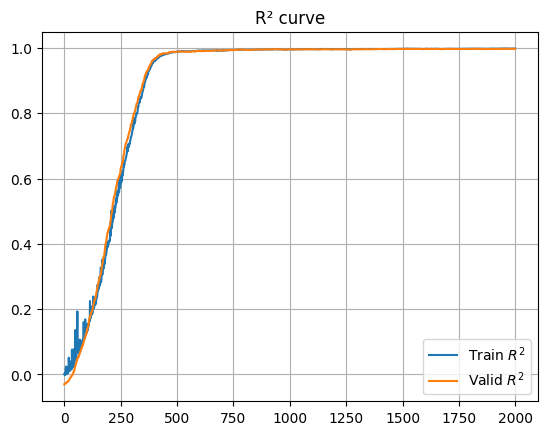

In [6]:
# REGRESSION

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pyperch import Trainer
from pyperch.config import TrainConfig, OptimizerConfig
from pyperch.core.metrics import MSE, R2
from pyperch.utils import plot_losses

# ------------------------------
# Repro
# ------------------------------
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# ------------------------------
# Regression dataset
# ------------------------------
X, y = make_regression(
    n_samples=1000,
    n_features=12,
    noise=0.2,
    random_state=seed
)
X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=64, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid)), batch_size=128)

# ------------------------------
# Model
# ------------------------------
class SimpleRegressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
    def forward(self, x):
        return self.net(x)

model = SimpleRegressor()
loss_fn = nn.MSELoss()

# ------------------------------
# SA optimizer config
# ------------------------------
opt_cfg = OptimizerConfig(
    name="sa",
    t=2.0,
    t_min=0.001,
    cooling=0.995,
    step_size=0.1,   # regression needs bigger moves
)

cfg = TrainConfig(
    device="cpu",
    seed=seed,
    max_epochs=2000,
    optimizer="sa",
    optimizer_config=opt_cfg,
    optimizer_mode="per_batch",
    metrics={"train": [MSE(), R2()], "valid": [MSE(), R2()]},
)
trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)

# R2 plot
epochs = history["epoch"]
train_r2 = history["train_metrics"].get("r2", [])
valid_r2 = history["valid_metrics"].get("r2", [])

plt.figure()
plt.plot(epochs, train_r2, label="Train $R^2$")
plt.plot(epochs, valid_r2, label="Valid $R^2$")
plt.legend()
plt.grid()
plt.title("R² curve")
plt.show()

Frozen layer unchanged: True


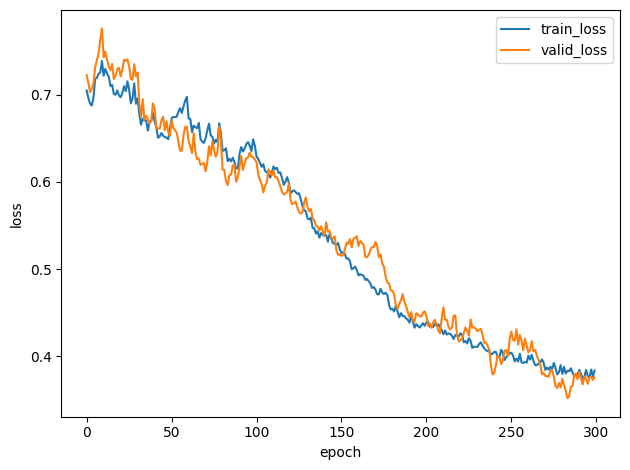

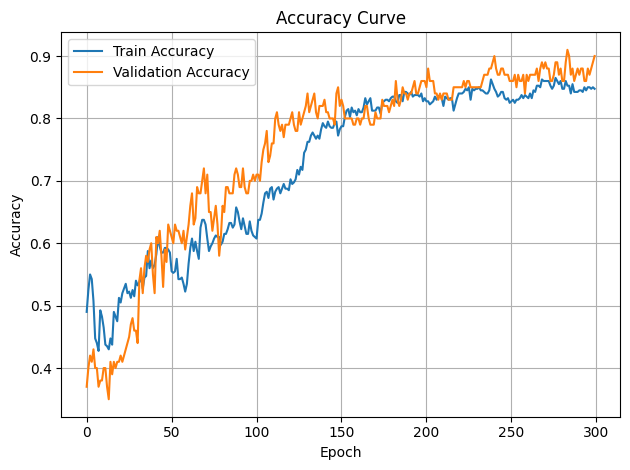

In [7]:
# FREEZING

import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from pyperch.config.schema import TrainConfig, OptimizerConfig
from pyperch.core.trainer import Trainer
from pyperch.core.metrics import Accuracy
from pyperch.utils import plot_losses, plot_accuracy

# ------------------------------
# Dummy data
# ------------------------------
np.random.seed(42)
X = np.random.randn(500, 10).astype(np.float32)
y = (X[:, :3].sum(axis=1) > 0).astype(np.int64)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train), torch.tensor(y_train)), batch_size=32, shuffle=True)
valid_loader = DataLoader(TensorDataset(torch.tensor(X_valid), torch.tensor(y_valid)), batch_size=32)

# ------------------------------
# Model
# ------------------------------
class SimpleClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        return self.net(x)

model = SimpleClassifier()
loss_fn = nn.CrossEntropyLoss()

original_w0 = model.net[0].weight.detach().clone()

# ------------------------------
# Freeze config
# ------------------------------
opt_cfg = OptimizerConfig(
    name="sa",
    t=2.0,
    t_min=0.001,
    cooling=0.995,
    step_size=0.05,
)

cfg = TrainConfig(
    device="cpu",
    seed=42,
    max_epochs=300,
    optimizer="sa",
    optimizer_config=opt_cfg,
    optimizer_mode="per_batch",
    metrics={"train": [Accuracy()], "valid": [Accuracy()]},
    layer_modes={
        "net.0.weight": "freeze",
        "net.0.bias": "freeze",
        "net.2.weight": "meta",
        "net.2.bias":  "meta",
    },
)
trainer = Trainer(model, loss_fn, cfg)
history = trainer.fit(train_loader, valid_loader)

print("Frozen layer unchanged:", torch.allclose(original_w0, model.net[0].weight.detach()))

plot_losses(history)
plot_accuracy(history)

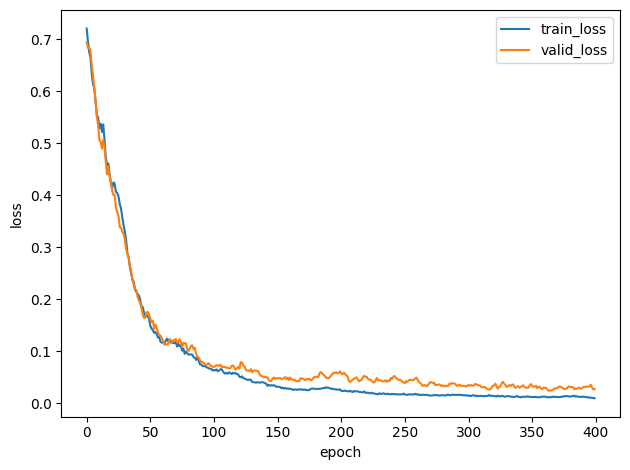

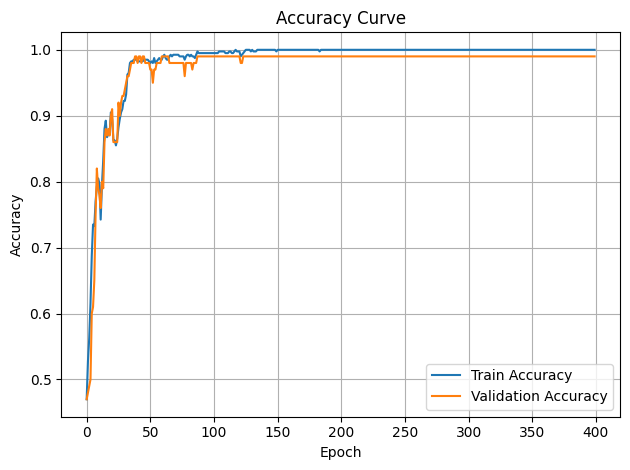

In [8]:
#hybrid test: 

# ------------------------------------------------------------
# Hybrid Layer Modes: grad + meta
# ------------------------------------------------------------

model = SimpleClassifier()

opt_cfg = OptimizerConfig(
    name="sa",
    t=2.0,
    t_min=0.001,
    cooling=0.995,
    step_size=0.05,
)

cfg = TrainConfig(
    device="cpu",
    seed=42,
    max_epochs=400,
    optimizer="sa",
    optimizer_config=opt_cfg,
    optimizer_mode="per_batch",
    metrics={"train": [Accuracy()], "valid": [Accuracy()]},
    layer_modes={
        "net.0.weight": "grad",
        "net.0.bias": "grad",
        "net.2.weight": "meta",
        "net.2.bias":  "meta",
    },
)

trainer = Trainer(model, nn.CrossEntropyLoss(), cfg)
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)
plot_accuracy(history)

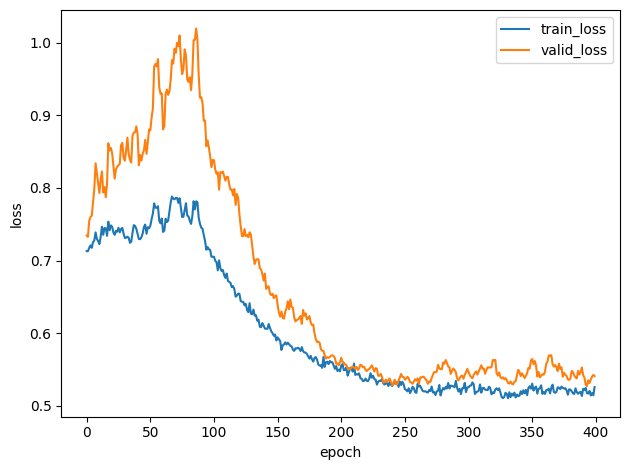

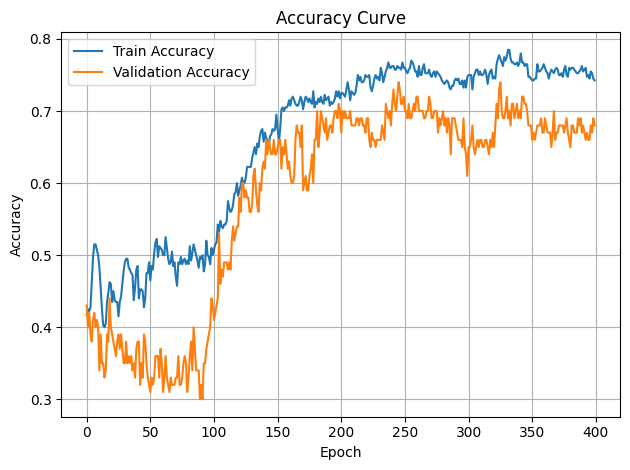

In [9]:
#freeze + hybrid
# ------------------------------------------------------------
# Freeze first layer
# Train middle with Adam
# Train output with SA
# ------------------------------------------------------------

model = SimpleClassifier()

opt_cfg = OptimizerConfig(
    name="sa",
    t=2.0,
    t_min=0.001,
    cooling=0.995,
    step_size=0.05,
)

cfg = TrainConfig(
    device="cpu",
    seed=42,
    max_epochs=400,
    optimizer="sa",
    optimizer_config=opt_cfg,
    optimizer_mode="per_batch",
    metrics={"train": [Accuracy()], "valid": [Accuracy()]},
    layer_modes={
        "net.0.weight": "freeze",
        "net.0.bias": "freeze",
        "net.2.weight": "meta",
        "net.2.bias":  "meta",
    },
)

trainer = Trainer(model, nn.CrossEntropyLoss(), cfg)
history = trainer.fit(train_loader, valid_loader)

plot_losses(history)
plot_accuracy(history)
